I'm experimenting with a "constant" ICA fit in all of our objects.  Since we have a good high-S/N sample in the LOFAR objects, use those at first.

In [1]:
from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import Column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import richardsplot
import os

/Users/trevormccaffrey/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
#Load the metadata of all 8403 objects
dat = pd.read_csv("data/grdr7.8403col.radec.platemjdfiber.csv")
dat.head()

,name,RA_1,Dec_1,RA_2,DEC_2,REDSHIFT,PLATE,FIBER,MJD
0,095004.94-002012.2,147.520612,-0.336744,147.520615,-0.336744,1.7756,267,275,51608
1,095938.28-003500.8,149.909527,-0.583571,149.909531,-0.583571,1.8766,268,59,51633
2,101033.44-004724.5,152.639355,-0.790145,152.639359,-0.790145,1.6675,270,213,51909
3,101100.92+002039.4,152.753859,0.344291,152.753860,0.344291,1.7487,270,491,51909
4,101826.85-000951.1,154.611911,-0.164201,154.611908,-0.164201,1.8156,271,152,51883


In [3]:
z     = dat[["REDSHIFT"]].values.flatten()
plate = dat[["PLATE"]].values.flatten()
mjd   = dat[["MJD"]].values.flatten()
fiber = dat[["FIBER"]].values.flatten()

In [4]:
#Gather data for kth spectrum
hdul_spec = fits.open("data/VLAspectra_all8403/lite/0876/spec-0876-52669-0006.fits") #navigate to each fits file and open
sdss_loglam = hdul_spec[1].data["loglam"]
sdss_wave = 10.**(sdss_loglam)  #x-axis: wavelength
#sdss_wave /= (1+list(redshift)[k])
sdss_flux = hdul_spec[1].data["flux"]

In [5]:
sdss_wave

array([3810.659 , 3811.5356, 3812.4126, ..., 9200.257 , 9202.379 ,
       9204.495 ], dtype=float32)

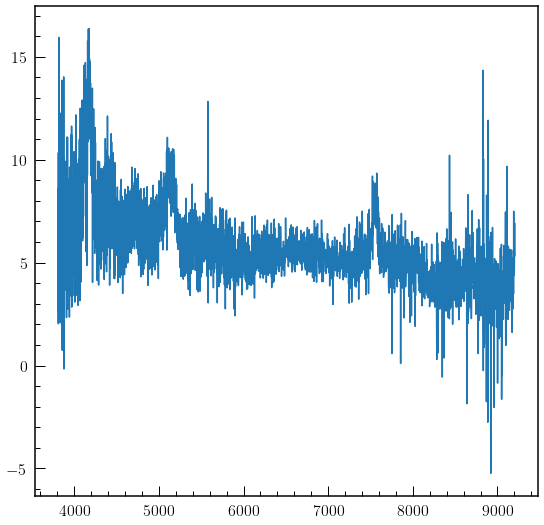

In [6]:
fig = plt.figure(figsize=(9,9))
plt.plot(sdss_wave, sdss_flux)
plt.show()

In [7]:
min(sdss_wave), max(sdss_wave)

(3810.659, 9204.495)

In [8]:
min(z), max(z)

(1.6261999607086182, 2.0887000560760502)

In [9]:
#Will want to save homogeneous arrays of each QSO's wavelength, flux, and inverse variance
spectra = np.array([])
wave    = np.array([])
ivar    = np.array([])

for red, pl, mj, fib in zip(z, plate, mjd, fiber):
    try:
        hdul_spec = fits.open("data/VLAspectra_all8403/lite/%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        print("data/VLAspectra_all8403/lite/%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
        
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    
    #Want the same wavelength range for each array
    wavemask   = ((sdss_wave>1470) & (sdss_wave<2875))
    sdss_flux  = sdss_flux[wavemask]
    sdss_flux /= np.median(sdss_flux) #normalize spectrum
    sdss_ivar  = sdss_ivar[wavemask]
    sdss_wave  = sdss_wave[wavemask]
    hdul_spec.close()
    
    if len(spectra) < 1:
        spectra = np.append(spectra, sdss_flux)
        wave = np.append(wave, sdss_wave)
        ivar = np.append(ivar, sdss_ivar)
    else:
        if len(sdss_flux) >= 2913:
            spectra = np.vstack((spectra, sdss_flux[:2913])) #Some might have one extra pixel
            wave = np.vstack((wave, sdss_wave[:2913]))
            ivar = np.vstack((ivar, sdss_ivar[:2913]))

data/VLAspectra_all8403/lite/2516/spec-2516-54240-0119.fits NOT FOUND
data/VLAspectra_all8403/lite/2516/spec-2516-54240-0125.fits NOT FOUND
data/VLAspectra_all8403/lite/2256/spec-2256-53859-0031.fits NOT FOUND


In [10]:
spectra.shape

(8394, 2913)

Not sure why 3 spectra are missing, but that doesn't really matter right now.  Note that it takes much more time to load in the data than it does to actually run ICA on it...

In [11]:
from sklearn.decomposition import FastICA

#Set ICA parameters
spec_mean = spectra.mean(0)
n_components = 4
ica = FastICA(n_components - 1)#, tol=0.01, max_iter=200)
ica.fit(spectra)
ica_comp = np.vstack([spec_mean,ica.components_]) #Add the mean to the components

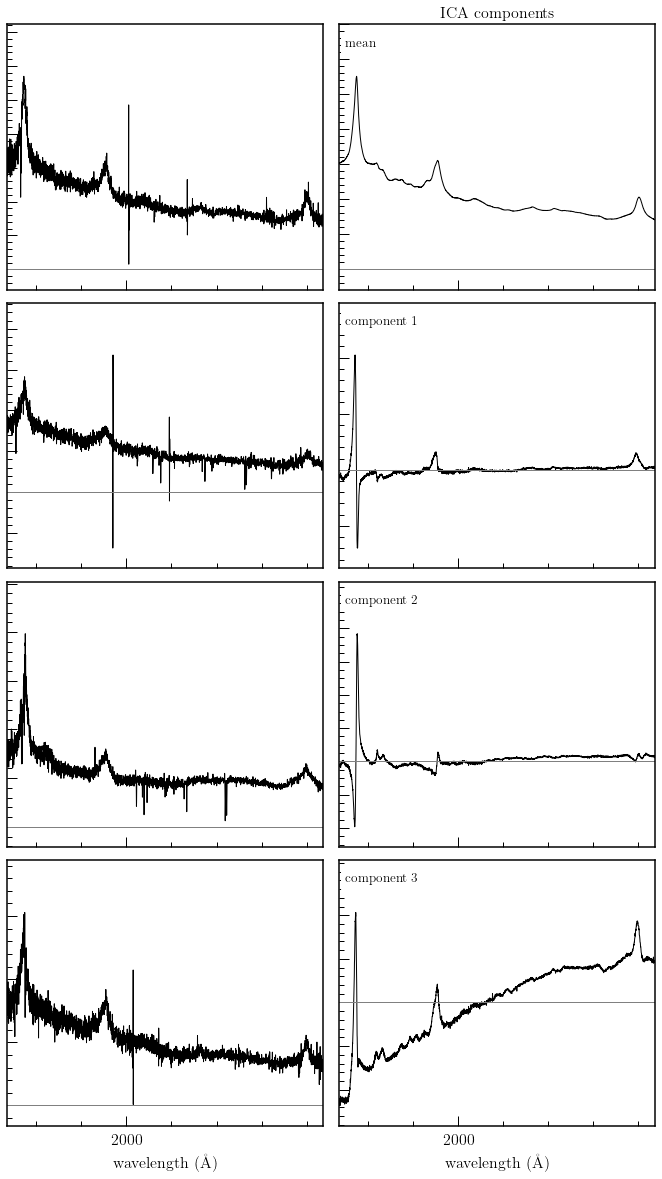

In [12]:
#Make plots
fig = plt.figure(figsize=(10, 18))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = 'ICA components'

for j in range(n_components):
    
    # plot the components
    ax = fig.add_subplot(n_components, 2, 2*j+2)
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel(r'wavelength ${\rm (\AA)}$')
    ax.plot(wave[0], ica_comp[j], '-k', lw=1)

    # plot zero line
    xlim = [min(wave[0]), max(wave[0])]
    ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax.set_xlim(xlim)

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)

    # plot the first j spectra
    ax2 = fig.add_subplot(n_components, 2, 2*j+1)
    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    ax2.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax2.set_xlabel(r'wavelength ${\rm (\AA)}$')
    ax2.plot(wave[0], spectra[j], '-k', lw=1)
    
    # plot zero line
    ax2.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax2.set_xlim(xlim)

    if j == 0:
        ax.set_title(titles, fontsize='medium')

    if j == 0:
        label = 'mean'
    else:
        label = 'component %i' % j

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax2.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)


    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='w', fc='w'),
            fontsize='small')

plt.show()

See how well the components+weights reconstruct the spectra.  (Though I'm not sure this is the best way to compute the weights???)

In [13]:
ica_comp

array([[ 1.52442735e+00,  1.52626233e+00,  1.51576513e+00, ...,
         7.07166633e-01,  7.06186892e-01,  7.06131100e-01],
       [-7.11700867e-05, -4.85601882e-05, -5.81993491e-05, ...,
         3.40008850e-05,  2.01556931e-05,  2.27997267e-05],
       [-1.74573993e-05, -2.95520759e-05, -2.52988227e-05, ...,
         2.07388254e-05,  3.02144068e-05,  2.87350323e-05],
       [-1.16016580e-04, -1.13421679e-04, -1.15754145e-04, ...,
         4.80620137e-05,  4.76392591e-05,  4.73980012e-05]])

Weights wrong?  Re-try with an MCMC fit.

In [15]:
from scipy import stats
from scipy import optimize

comp = ica_comp[1:]

def reconstruct_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(w*comp[n] for (n, w) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=reconstruct_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(num_weights, data, model=reconstruct_fit):
    theta_0 = num_weights * [0]
    neg_logL = lambda theta: -logL(theta, data, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=True)

In [16]:
comp[0].shape

(2913,)

In [17]:
#Note this is what Rankine et al. used and is MUCH faster than the scipy method above

from lmfit import minimize, Parameters

comp = ica_comp[1:]

def residual(params, comps, data, eps_data):
    #theta = 

    model = sum(params[w].value*comps[n] for (n, w) in enumerate(params))

    return (data-model)**2 * eps_data

params = Parameters()
#Define parameters (they are simply the weights)
params.add('W1', value=0)#, min=-100, max=100)
params.add('W2', value=0)#, min=-100, max=100)
params.add('W3', value=0)#, min=-100, max=100)
"""params.add('W4', value=0)#, min=-100, max=100)
params.add('W5', value=0)#, min=-100, max=100)
params.add('W6', value=0)
params.add('W7', value=0)
params.add('W8', value=0)
params.add('W9', value=0)
params.add('W10', value=0)"""

out = minimize(residual, params, args=(comp, spectra[0], ivar[0]), method="lbfgsb")

In [18]:
weights = []
for i in out.params: weights.append(out.params[i].value)

data = np.vstack([wave[2], spectra[2], 1/np.sqrt(ivar[2])])
weights = best_theta(len(comp), data)

In [19]:
weights

[9851.065420690305, 14664.202400927641, -9617.410117040672]

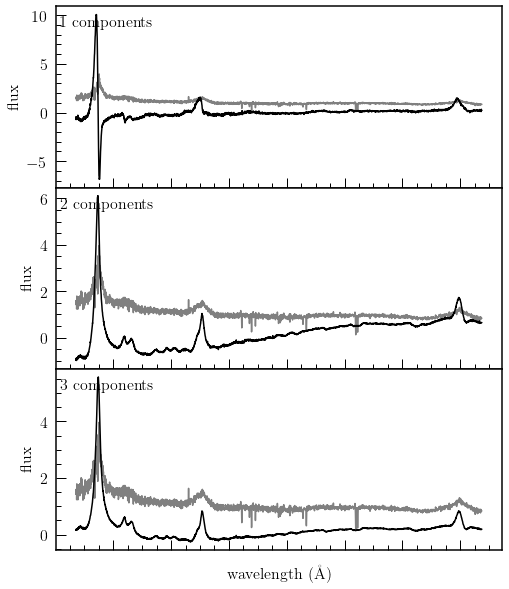

In [20]:
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(8, 10))
fig.subplots_adjust(hspace=0)

for i, n in enumerate(range(len(comp))):
    ax = fig.add_subplot(len(weights),1,1 + i)
    ax.plot(wave[2], spectra[2], '-', c='gray')
    ax.plot(wave[2], np.dot(weights[:(n+1)], comp[:(n+1)]), '-k')

    if i < 4:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    #ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    text = "%i components\n" % (n+1)
    #text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
        
    ax.text(0.01, 0.95, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

That's pretty good, but still two questions:
- Why are the weights so big??  (Maybe this can be remedied by normalizing the spectra?) Answer: Normalizing didn't fix, so I'm still not sure; maybe should still be adding to mean?  But that's not how I reconstructed the spectra with the weights+components that Amy gave me last time...
- How did the Cambridge folks make their actual components so clean?  (That is, not noisy -- we can't get a noiseless reconstruction if each component is just as noisy!)  Answer: Train with more spectra


I think it makes sense to look at the Allen et al. papers more closely and ask how to generate *separate* continuum and emission-line components -- because right now, it really looks like we're sacrificing accuracy of one or the other no matter how many components are used...


Although maybe it's a good idea to step back and see if we can do the fitting with the components given to us by Amy:

In [21]:
comps = pd.read_csv("ICAcomponents_amy/amy_12603000_10c_180421.comp", sep="   ", 
                    names=["c1","c2","c3","c4","c5","c6","c7","c8","c9","c10"])
comps.head()

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
0,24.698806,16.686412,7.688548,15.341052,23.578585,26.683294,13.495317,6.538646,1.664259,2.183455
1,24.739279,16.817581,7.595197,15.180562,23.401660,26.911398,13.390482,6.503097,1.688669,2.158522
2,24.224352,17.866104,6.588490,14.184640,20.963588,31.500265,13.759934,6.013081,2.042107,2.182271
3,23.490432,19.006920,5.655106,13.356560,18.174907,36.655364,14.089166,5.374100,2.372019,2.262592
4,22.691346,20.734796,4.060175,11.884361,14.053418,44.351801,14.582722,4.537810,2.668855,2.364192


In [22]:
wave = pd.read_csv("ICAcomponents_amy/wav_12603000.dat", names=["wave"])
wl = wave[["wave"]].values.flatten()
wave.head()

,wave
0,1260.0855
1,1260.3756
2,1260.6659
3,1260.9562
4,1261.2466


In [23]:
for n,i in enumerate(comps): print(n,i)

0 c1
1 c2
2 c3
3 c4
4 c5
5 c6
6 c7
7 c8
8 c9
9 c10


In [24]:
wl

array([1260.0855, 1260.3756, 1260.6659, ..., 2998.472 , 2999.1625,
       2999.8532])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


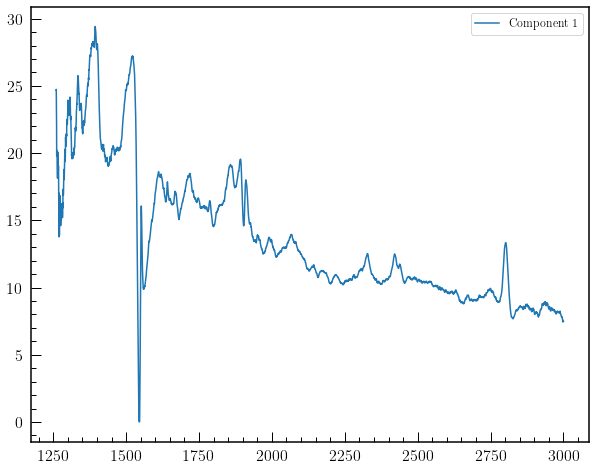

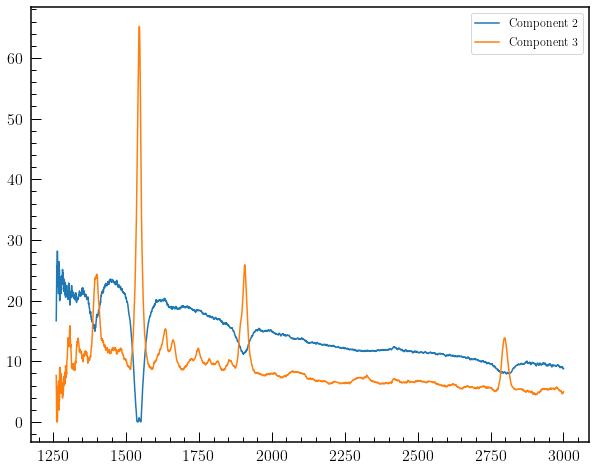

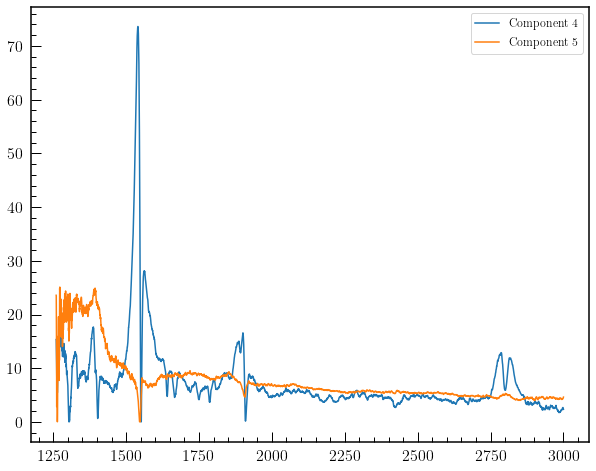

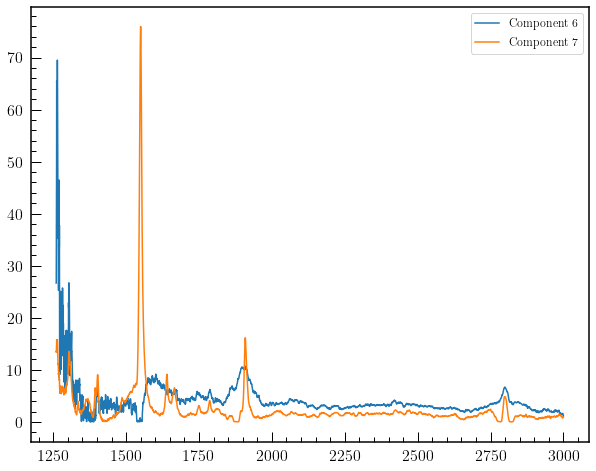

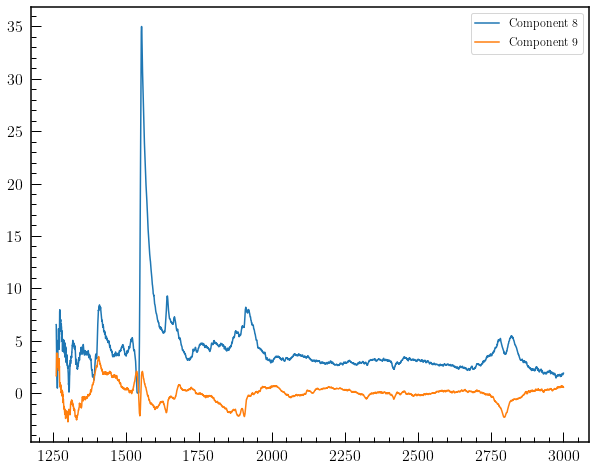

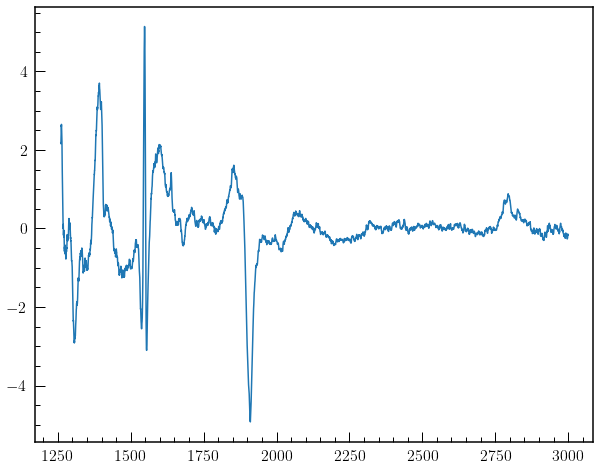

In [25]:
fig = plt.figure(figsize=(10,8))

for n,i in enumerate(comps):
    if (n+1) % 2 == 0:
        plt.legend(loc="best")
        plt.show()
        fig = plt.figure(figsize=(10,8))
    plt.plot(wl, comps[i].values.flatten().astype(float), label="Component %d" % (n+1))
    
plt.show()

Now do the minimization with these components

In [26]:
wl

array([1260.0855, 1260.3756, 1260.6659, ..., 2998.472 , 2999.1625,
       2999.8532])

In [27]:
#Only want to use a certain wavelength range of the components
ica_wave = ((wl>1470)&(wl<2875))
wl_ica = wl[ica_wave]

In [28]:
#make an array of the components to feed to minimize
components = np.array([])
for n,i in enumerate(comps):
    if n==0:
        components = np.append(components, comps[[i]].values.flatten().astype(float)[ica_wave])
    else:
        components = np.vstack((components, comps[[i]].values.flatten().astype(float)[ica_wave]))

In [29]:
components.shape

(10, 2913)

In [30]:
params = Parameters()
#Define parameters (they are simply the weights)
params.add('W1', value=0)#, min=-100, max=100)
params.add('W2', value=0)#, min=-100, max=100)
params.add('W3', value=0)#, min=-100, max=100)
params.add('W4', value=0)#, min=-100, max=100)
params.add('W5', value=0)#, min=-100, max=100)
params.add('W6', value=0)
params.add('W7', value=0)
params.add('W8', value=0)
params.add('W9', value=0)
params.add('W10', value=0)

out_amy = minimize(residual, params, args=(components, spectra[0], ivar[0]))#, method="lbfgsb")

In [31]:
out_amy

At first glance, already a much better chi-square; how do they actually perform?

In [32]:
weights = []
for i in out_amy.params: weights.append(out_amy.params[i].value)

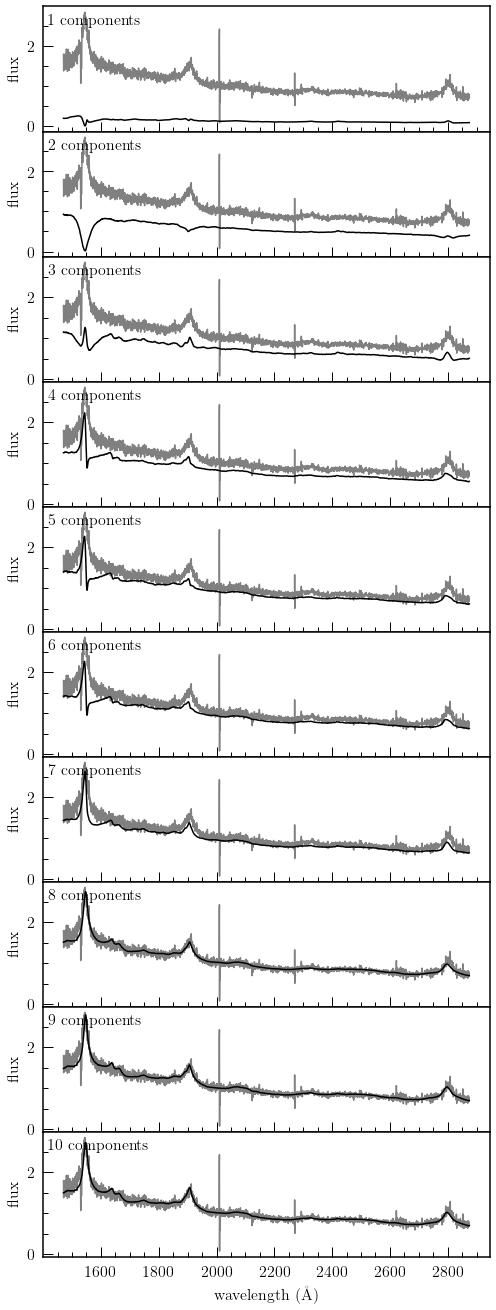

In [33]:
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(8, 23))
fig.subplots_adjust(hspace=0)

for i, n in enumerate(range(len(components))):
    ax = fig.add_subplot(len(weights),1,1 + i)
    ax.plot(wl_ica, spectra[0], '-', c='gray')
    ax.plot(wl_ica, np.dot(weights[:(n+1)], components[:(n+1)]), '-k')

    if i < 4:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    #ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    text = "%i components\n" % (n+1)
    #text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
        
    ax.text(0.01, 0.95, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

Awesome, it works.  For now, it's just good that we can now do our own ICA measyrements.  But we really still want to use a single set of components -- or turn this into some kind of nonlinear process.

Maybe the secret is just separately finding components for the galaxy???

Have a look at the other sets of components...

In [34]:
cmod = pd.read_csv("ICAcomponents_amy/amy_12603000_10c_180421.comp", sep="\s+", 
                    names=["c1","c2","c3","c4","c5","c6","c7","c8","c9","c10"])

clow = pd.read_csv("ICAcomponents_amy/amy_12753000_lowew_10c_181101_v1.comp", sep="\s+", 
                    names=["c1","c2","c3","c4","c5","c6","c7","c8","c9","c10"])

chigh = pd.read_csv("ICAcomponents_amy/amy_12653000_hew_hsn_7c_190302.comp", sep="\s+", 
                    names=["c1","c2","c3","c4","c5","c6","c7"])

chigh.head()

,c1,c2,c3,c4,c5,c6,c7
0,0.029352,21.131907,1.849054,6.627145,3.014905,-0.692857,0.047240
1,0.040435,21.345699,1.454935,6.415685,2.845428,-0.676061,0.236393
2,0.050010,21.377104,1.303095,6.243556,2.912823,-0.646095,0.208662
3,0.062440,21.326774,1.182024,6.375846,2.807746,-0.699397,0.145732
4,0.083303,21.481439,0.818819,6.176292,2.792313,-0.817434,0.010118


In [35]:
min(wl[ica_wave]), max(wl[ica_wave])

(1470.2798, 2874.7495)

In [36]:
wave_mod = pd.read_csv("ICAcomponents_amy/wav_12603000.dat", names=["wave"])
wave_low = pd.read_csv("ICAcomponents_amy/wav_12753000.dat", names=["wave"])
wave_high= pd.read_csv("ICAcomponents_amy/wav_12653000.dat", names=["wave"])

In [37]:
modmask = np.array(((wave_mod>1470) & (wave_mod<2875))).flatten()
lowmask = np.array(((wave_low>1470) & (wave_low<2875))).flatten()
highmask= np.array(((wave_high>1470) & (wave_high<2875))).flatten()

wave_mod = wave_mod[modmask]
wave_low = wave_low[lowmask]
wave_high= wave_high[highmask]

In [38]:
for n,i in enumerate(cmod): print(n,i)

0 c1
1 c2
2 c3
3 c4
4 c5
5 c6
6 c7
7 c8
8 c9
9 c10


In [39]:
#make an array of the components to feed to minimize
components_mod = np.array([])
components_low = np.array([])
components_high= np.array([])

for n,i in enumerate(cmod):
    if n==0:
        components_mod = np.append(components_mod, cmod[[i]].values.flatten().astype(float)[modmask])
        components_low = np.append(components_low, clow[[i]].values.flatten().astype(float)[lowmask])
        components_high= np.append(components_high, chigh[[i]].values.flatten().astype(float)[highmask])
    elif n < 7:
        components_mod = np.vstack((components_mod, cmod[[i]].values.flatten().astype(float)[modmask]))
        components_low = np.vstack((components_low, clow[[i]].values.flatten().astype(float)[lowmask]))
        components_high= np.vstack((components_high, chigh[[i]].values.flatten().astype(float)[highmask]))
    else:
        components_mod = np.vstack((components_mod, cmod[[i]].values.flatten().astype(float)[modmask]))
        components_low = np.vstack((components_low, clow[[i]].values.flatten().astype(float)[lowmask]))

In [40]:
components_mod.shape, components_low.shape, components_high.shape

((10, 2913), (10, 2913), (7, 2913))

In [41]:
len(components_mod)

10

In [42]:
#Wrap it all in a function

def residual(params, comps, data, eps_data):
    model = sum(params[w].value*comps[n] for (n, w) in enumerate(params))
    return (data-model)**2 * eps_data

def ica_fit(components, spectrum, ivar):
    params = Parameters()
    for i in range(len(components)):
        params.add('W%d' % (i+1), value=0)
        
    return minimize(residual, params, args=(components, spectrum, ivar), method="lbfgsb")

In [43]:
fit_mod = ica_fit(components_mod, spectra[0], ivar[0])

In [44]:
fit_mod

In [45]:
fit_mod.redchi

6.81183360412136e-05

Now can easily wrap this in a loop.  Amy says she used chi-square to determine which set of components provided the best fit, so we should do the same.

(Note also that the weights for mine were so big because I was determining the components *with the normalized spectra*.  Amy's components seem to be in real units, so it makes sense that the weights on them when applied to the normalized spectra are much smaller.)

In [46]:
fit_mod.params["W1"].value

0.009225100178420357

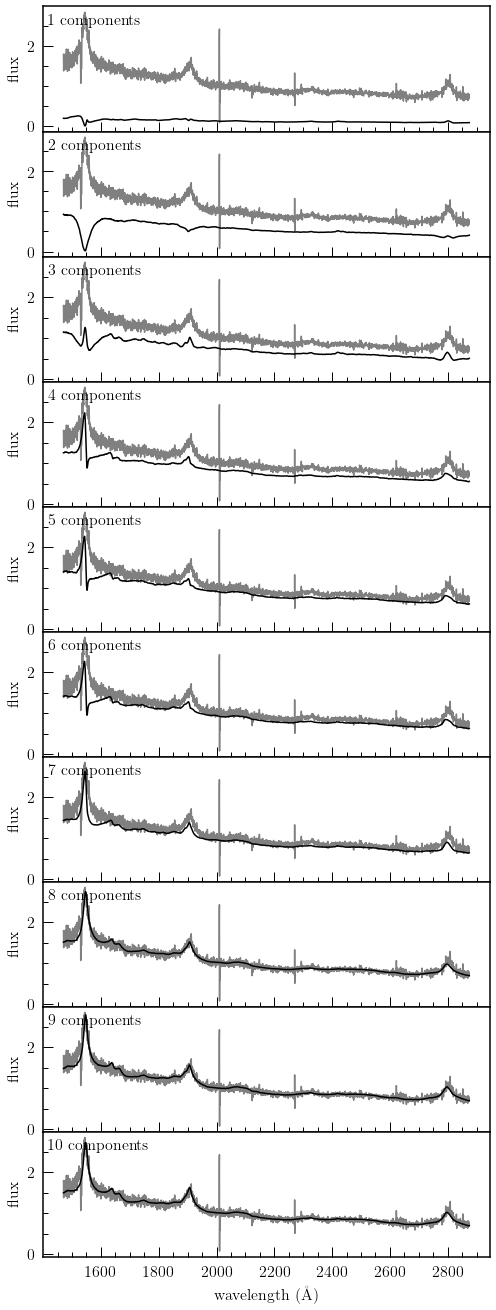

In [47]:
fig = plt.figure(figsize=(8, 23))
fig.subplots_adjust(hspace=0)

for i, n in enumerate(components_mod):
    #Need to bring together weights - see if there's a better way to do this
    weights = []
    for j in fit_mod.params: weights.append(fit_mod.params[j].value)
    
    ax = fig.add_subplot(len(weights),1,1 + i)
    ax.plot(wave_mod, spectra[0], '-', c='gray')
    ax.plot(wave_mod, np.dot(weights[:(i+1)], components_mod[:(i+1)]), '-k')

    #if i < 4:
    #    ax.xaxis.set_major_formatter(plt.NullFormatter())

    #ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    text = "%d components\n" % (i+1)
    #text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
        
    ax.text(0.01, 0.95, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


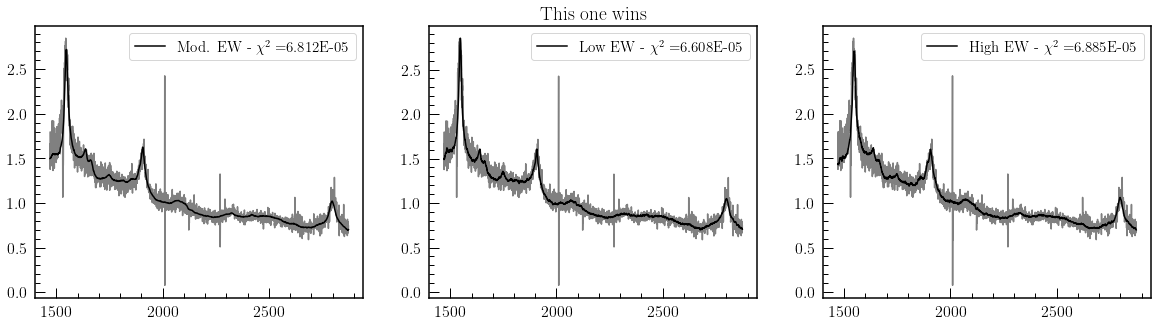

In [48]:
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(20,5))

fit_mod   = ica_fit(components_mod, spectra[0], ivar[0])
weights_mod = []
for i in fit_mod.params: weights_mod.append(fit_mod.params[i].value)
mod_chisq = fit_mod.redchi
ax1.plot(wave_mod, spectra[0], '-', c='gray')
ax1.plot(wave_mod, np.dot(weights_mod, components_mod), '-k', label="Mod. EW - $\chi^2=$%.3E" % (mod_chisq))
ax1.legend(loc="best", prop={"size":15})

fit_low   = ica_fit(components_low, spectra[0], ivar[0])
weights_low = []
for i in fit_low.params: weights_low.append(fit_low.params[i].value)
low_chisq = fit_low.redchi
ax2.plot(wave_low, spectra[0], '-', c='gray')
ax2.plot(wave_low, np.dot(weights_low, components_low), '-k', label="Low EW - $\chi^2=$%.3E" % (low_chisq))
ax2.legend(loc="best", prop={"size":15})

fit_high   = ica_fit(components_high, spectra[0], ivar[0])
weights_high = []
for i in fit_high.params: weights_high.append(fit_high.params[i].value)
high_chisq = fit_high.redchi
ax3.plot(wave_high, spectra[0], '-', c='gray')
ax3.plot(wave_high, np.dot(weights_high, components_high), '-k', label="High EW - $\chi^2=$%.3E" % (high_chisq))
ax3.legend(loc="best", prop={"size":15})

if mod_chisq < low_chisq and mod_chisq < high_chisq:
    ax1.set_title("This one wins")
elif low_chisq < mod_chisq and low_chisq < high_chisq:
    ax2.set_title("This one wins")
elif high_chisq < low_chisq and high_chisq < mod_chisq:
    ax3.set_title("This one wins")

It looks like they all do a good job.  But then again, this is a pretty clean spectrum to begin with.  Try on some others.

Gordon says we can't really use just the ICA weights for analysis since different objects use different sets of components.  But could we just use the same components anyway??  They may not produce the most accurate reconstructions, but even if the reconstruction isn't quite right, we may still be able to draw physical information from the weights applied...  Still gonna need to see how bad some of the "moderate EW" components reconstruct low+high EW objects...

We have >8000 to look at, but show the first say 15 in this notebook.  Wrap the above cell in a loop.

In [49]:
len(spectra)

8394

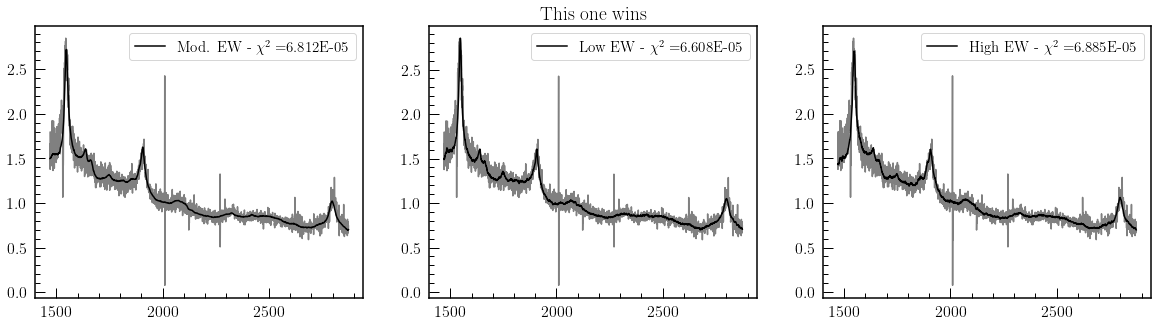

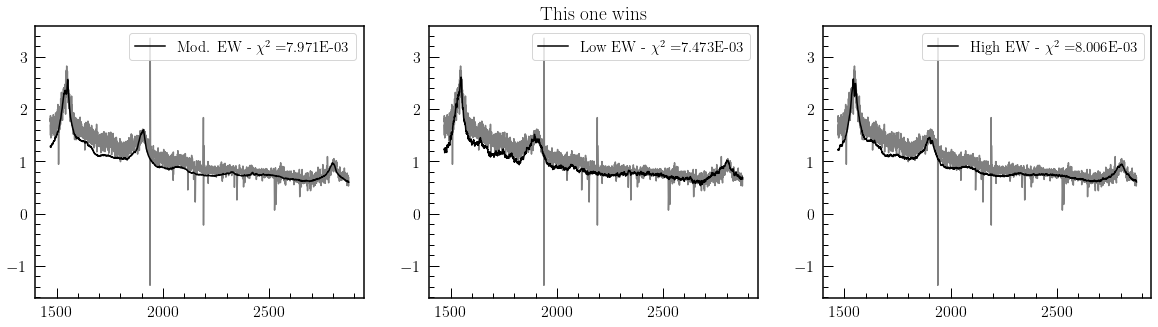

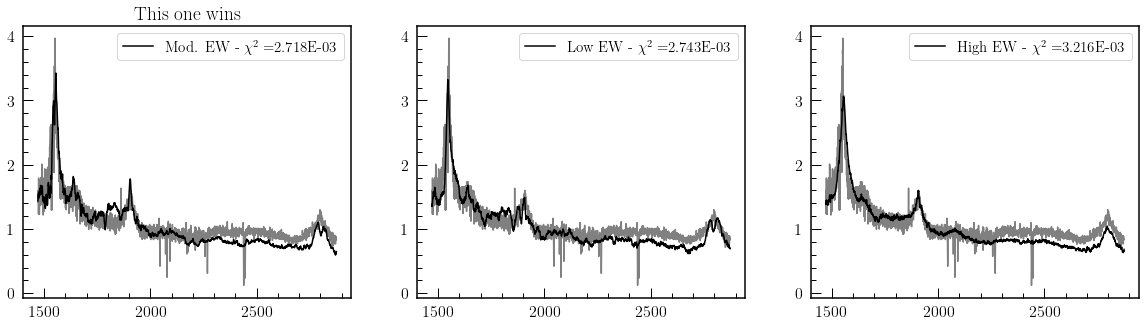

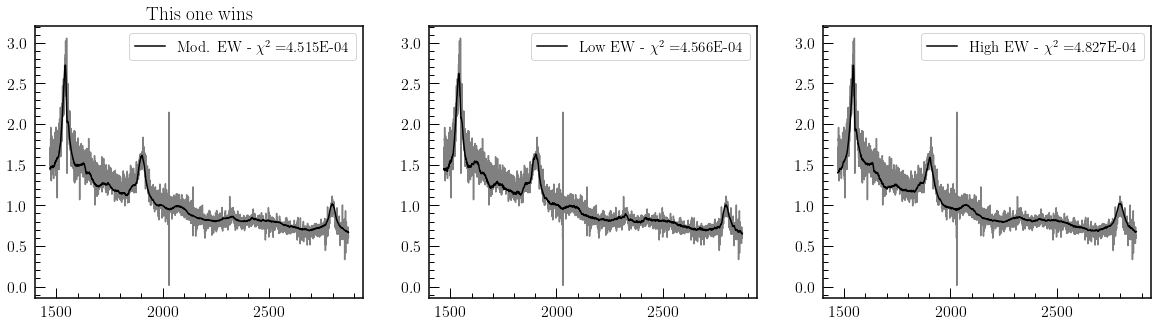

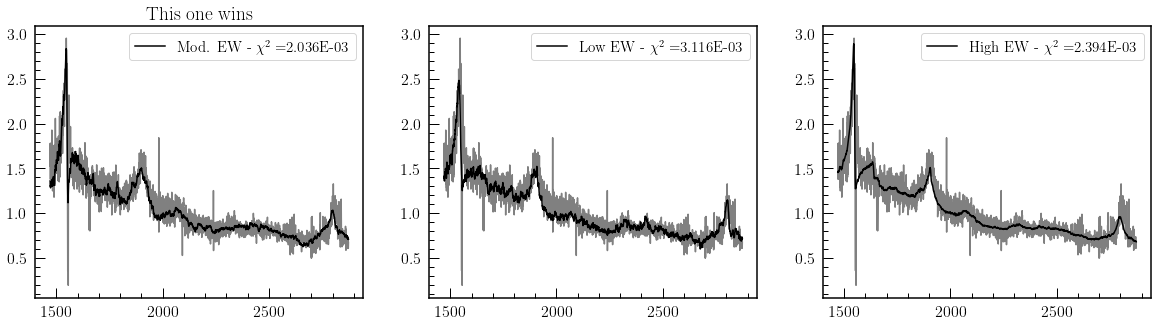

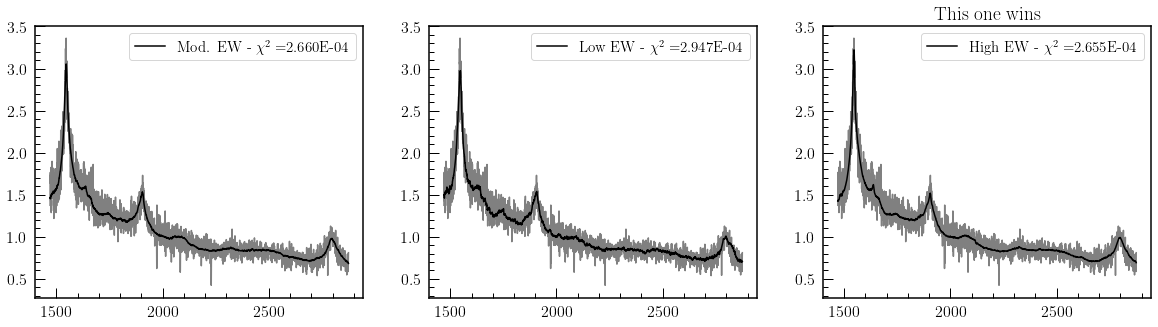

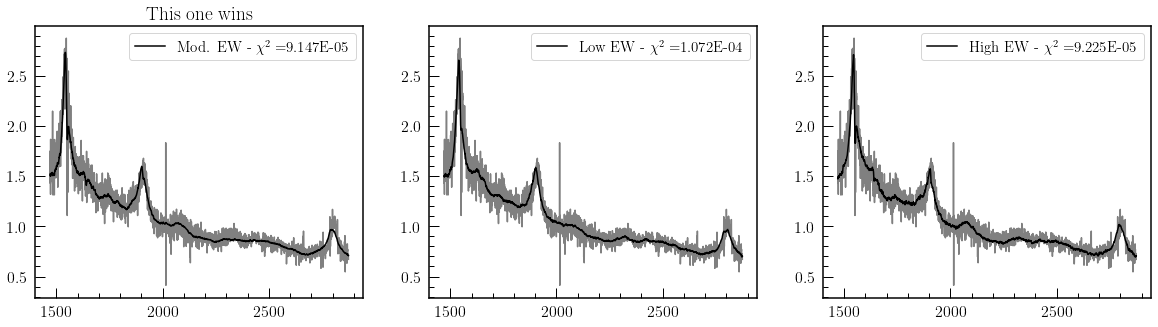

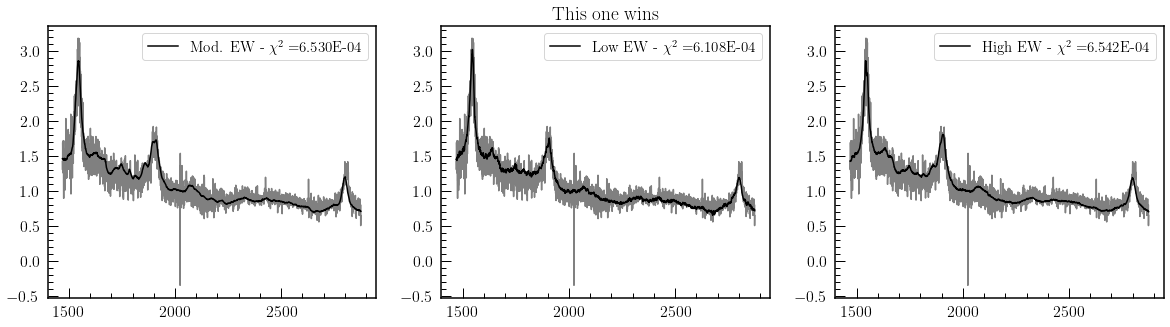

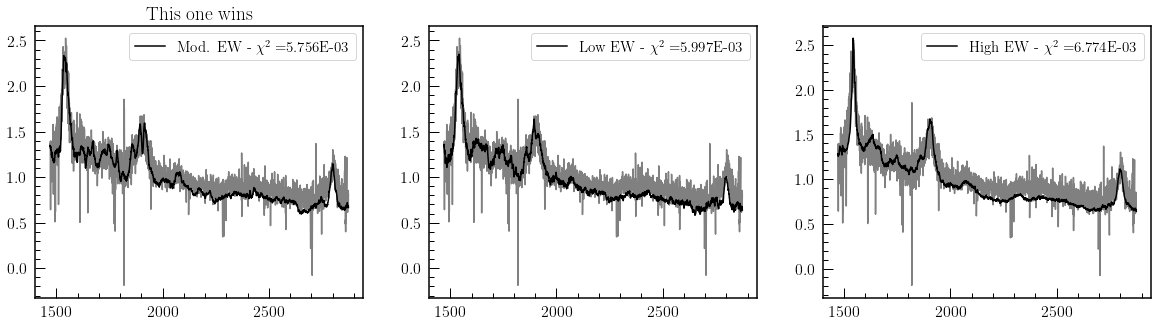

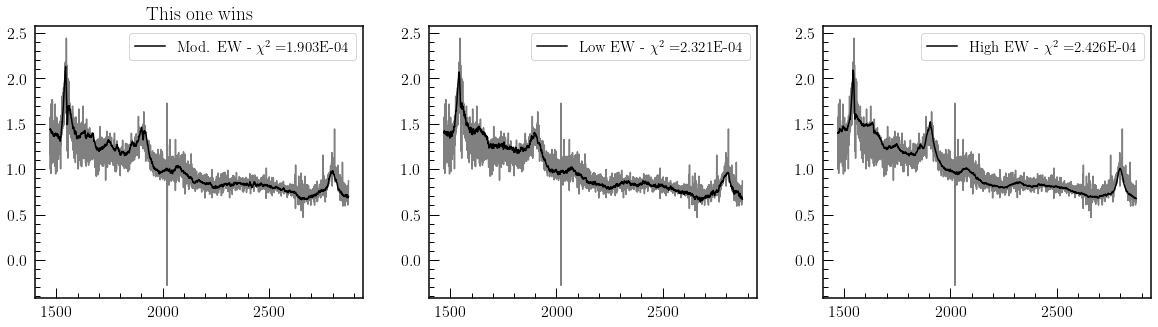

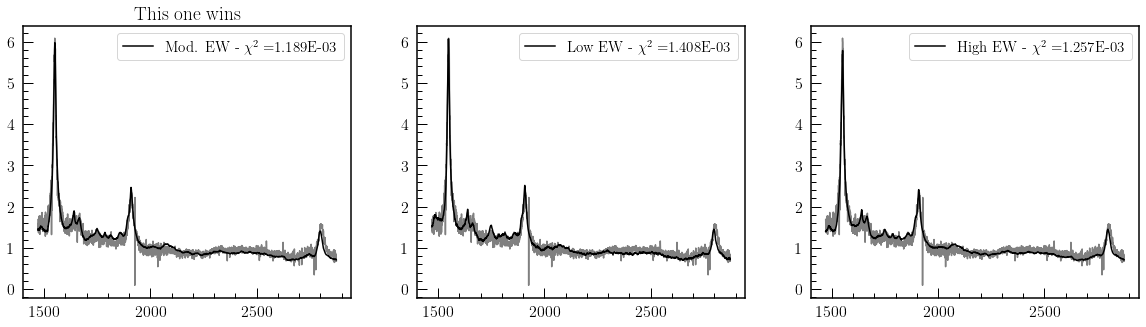

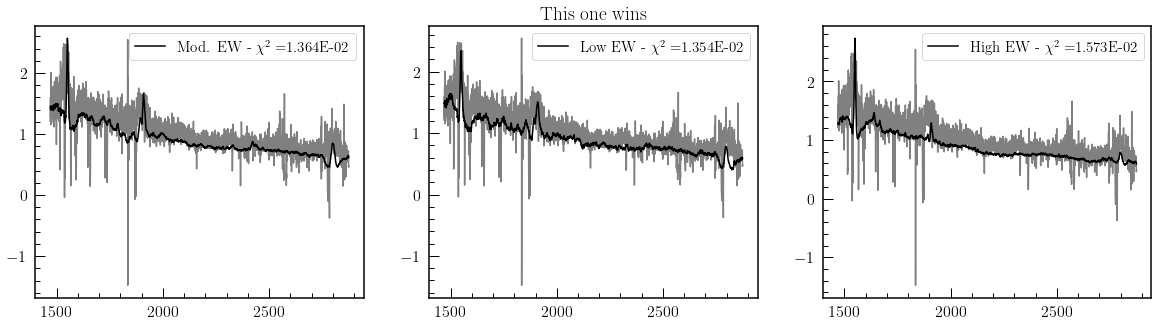

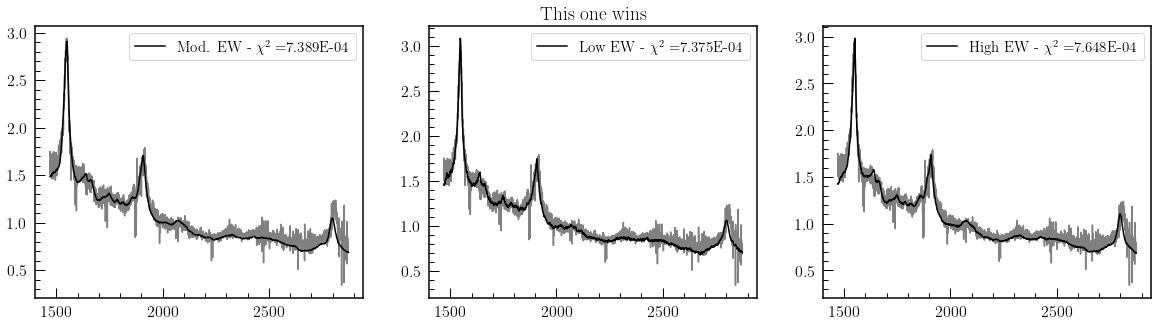

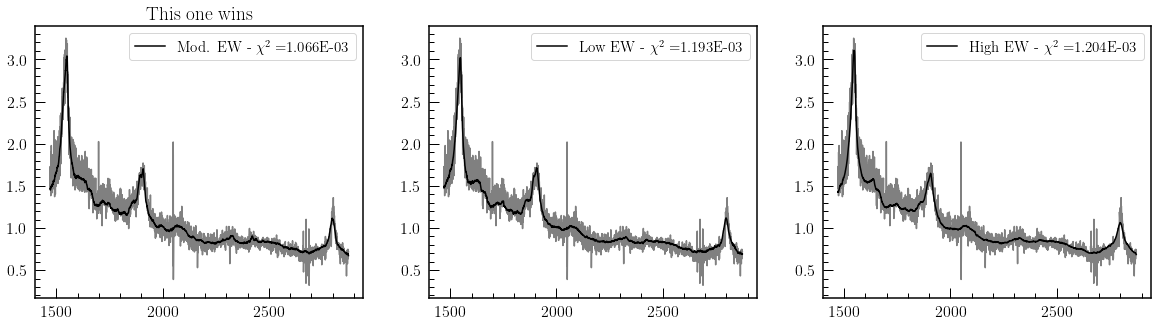

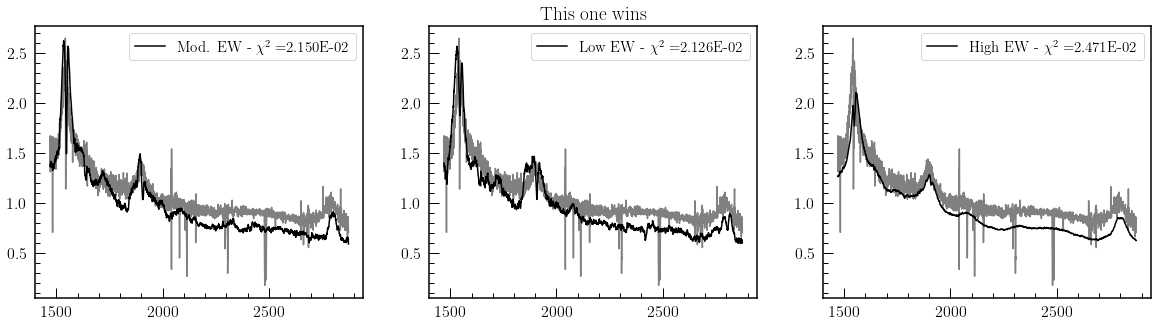

In [50]:
for k in range(15):
    fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(20,5))

    fit_mod   = ica_fit(components_mod, spectra[k], ivar[k])
    weights_mod = []
    for i in fit_mod.params: weights_mod.append(fit_mod.params[i].value)
    mod_chisq = fit_mod.redchi
    ax1.plot(wave_mod, spectra[k], '-', c='gray')
    ax1.plot(wave_mod, np.dot(weights_mod, components_mod), '-k', label="Mod. EW - $\chi^2=$%.3E" % (mod_chisq))
    ax1.legend(loc="best", prop={"size":15})

    fit_low   = ica_fit(components_low, spectra[k], ivar[k])
    weights_low = []
    for i in fit_low.params: weights_low.append(fit_low.params[i].value)
    low_chisq = fit_low.redchi
    ax2.plot(wave_low, spectra[k], '-', c='gray')
    ax2.plot(wave_low, np.dot(weights_low, components_low), '-k', label="Low EW - $\chi^2=$%.3E" % (low_chisq))
    ax2.legend(loc="best", prop={"size":15})

    fit_high   = ica_fit(components_high, spectra[k], ivar[k])
    weights_high = []
    for i in fit_high.params: weights_high.append(fit_high.params[i].value)
    high_chisq = fit_high.redchi
    ax3.plot(wave_high, spectra[k], '-', c='gray')
    ax3.plot(wave_high, np.dot(weights_high, components_high), '-k', label="High EW - $\chi^2=$%.3E" % (high_chisq))
    ax3.legend(loc="best", prop={"size":15})

    if mod_chisq < low_chisq and mod_chisq < high_chisq:
        ax1.set_title("This one wins")
    elif low_chisq < mod_chisq and low_chisq < high_chisq:
        ax2.set_title("This one wins")
    elif high_chisq < low_chisq and high_chisq < mod_chisq:
        ax3.set_title("This one wins")

    plt.show()

Not bad, but some still aren't really that great.  We should really be cleaning the spectra before giving them to ICA; I'm not sure that'll make a huge difference in determining the weights, but it's worth a try.

Amy also talks about "morphing" the spectra so they all have the same general shape.  I think they said that was specific to DR14 spectra (these are DR7), but we're going to want to extend this to DR14 eventually anyway, so should also figure that out.

They also use the morphology of CIII] and CIV to place priors on the weights, which supposedly greatly improves the reconstructions in the presence of strong absorption.